In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# ==================== 1. Load Dataset ====================
dataset_path = 'flowers'  # Ganti sesuai lokasi folder
batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names

# ==================== 2. Augmentasi & Preprocessing ====================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# ==================== 3. Feature Extraction ====================
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=img_size + (3,))
base_model.trainable = False  # Freeze semua layer

inputs = tf.keras.Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ==================== 4. Training Awal (Feature Extraction) ====================
print("\n>>> Training tahap 1 (Feature Extraction)...")
model.fit(train_ds, validation_data=val_ds, epochs=5)

# ==================== 5. Fine Tuning ====================
print("\n>>> Fine-tuning (Unfreeze layer akhir)...")
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Fine-tune 20 layer terakhir
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Optional: EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train ulang
model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[early_stop])

# ==================== 6. Evaluasi ====================
print("\n>>> Evaluasi model:")
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ==================== 7. Simpan Model ====================
model.save("models/flower_classifier_densenet.h5")
print("\n>>> Model disimpan ke: flower_classifier_densenet.h5")

# ==================== 8. Fungsi Prediksi Gambar Baru ====================
def predict_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_idx = np.argmax(preds)
    confidence = np.max(preds)

    plt.imshow(img.astype("uint8"))
    plt.title(f"Prediksi: {class_names[class_idx]} ({confidence:.2%})")
    plt.axis("off")
    plt.show()

Found 4317 files belonging to 5 classes.
Using 3022 files for training.
Found 4317 files belonging to 5 classes.
Using 1295 files for validation.

>>> Training tahap 1 (Feature Extraction)...
Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.4723 - loss: 1.3131 - val_accuracy: 0.8355 - val_loss: 0.5276
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7861 - loss: 0.5895 - val_accuracy: 0.8695 - val_loss: 0.4044
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8279 - loss: 0.4894 - val_accuracy: 0.8865 - val_loss: 0.3613
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8583 - loss: 0.4186 - val_accuracy: 0.8950 - val_loss: 0.3315
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8738 - loss: 0.3733 - val_accuracy: 0.8981 - val_loss: 0.3206

>>> Fine-tuning (Unfreeze layer akhir)...
Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.8559 - loss: 0.4234 - val_accuracy: 0.8927 - val_loss: 0.3192
Epoch 2/5


Classification Report:
              precision    recall  f1-score   support

       daisy       0.91      0.89      0.90       214
   dandelion       0.92      0.91      0.92       296
        rose       0.85      0.86      0.85       257
   sunflower       0.93      0.94      0.93       218
       tulip       0.87      0.87      0.87       310

    accuracy                           0.89      1295
   macro avg       0.90      0.89      0.90      1295
weighted avg       0.89      0.89      0.89      1295


>>> Model disimpan ke: flower_classifier_densenet.h5


# Antarmuka Pada STREAMLIT
# URL: https://recognizeflowers.streamlit.app/

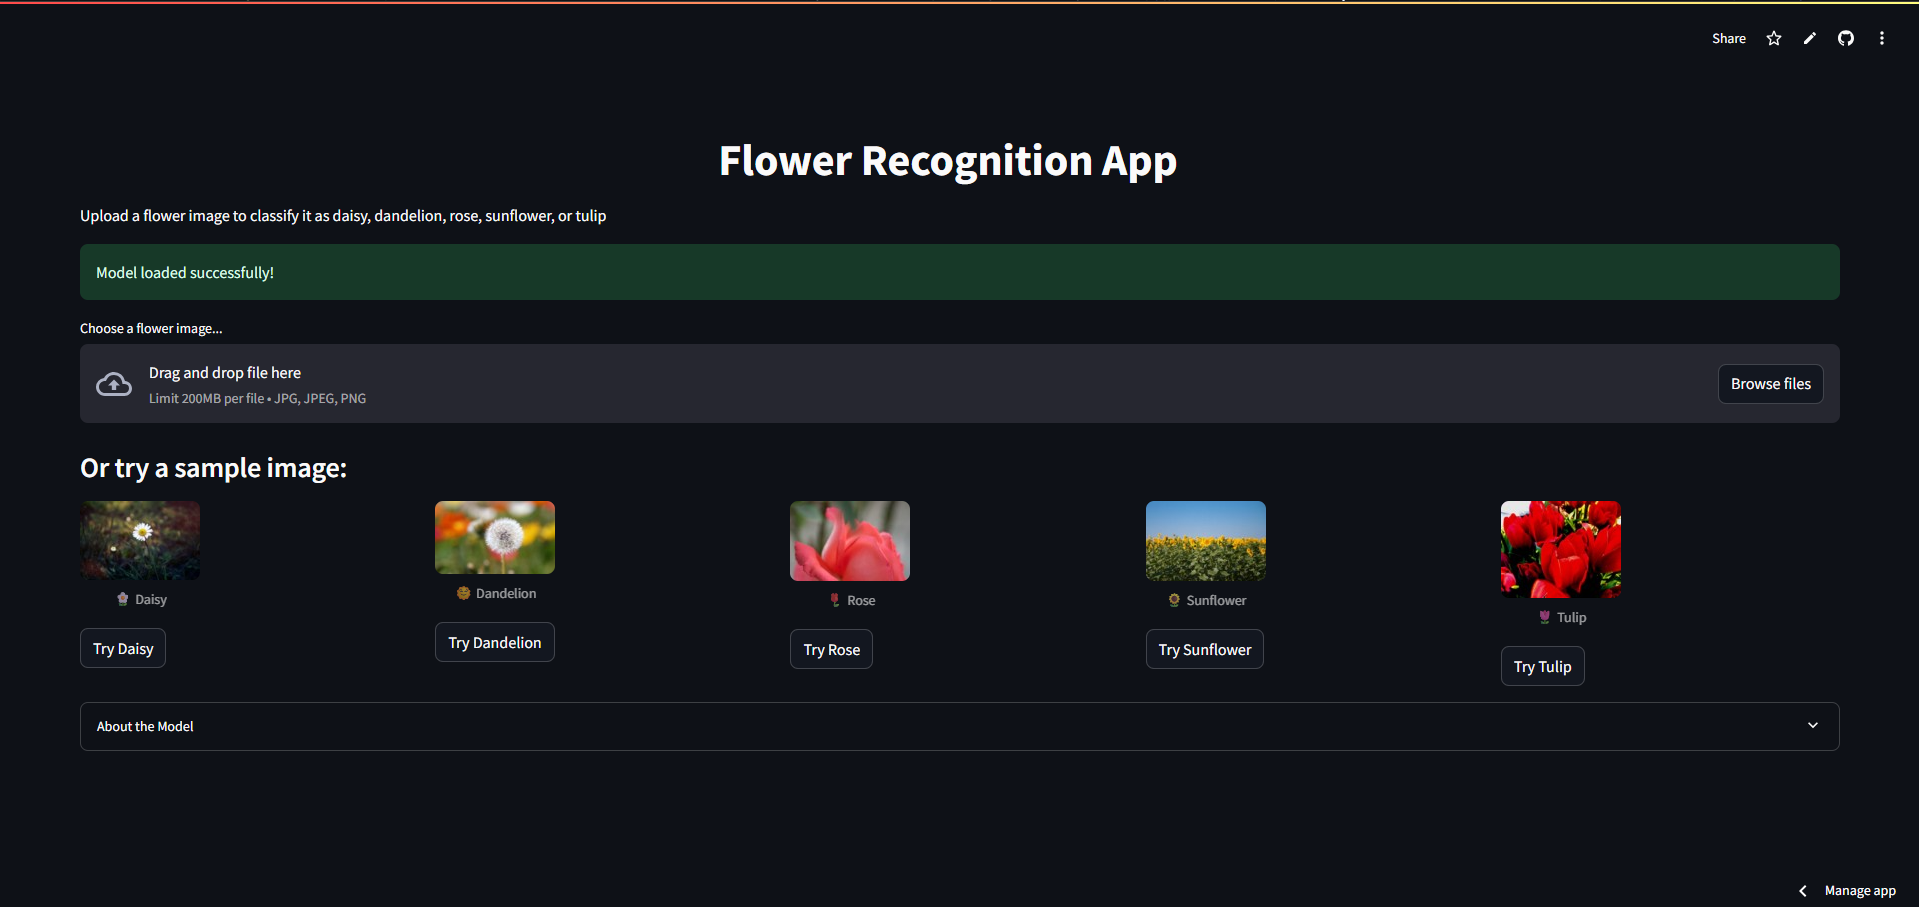
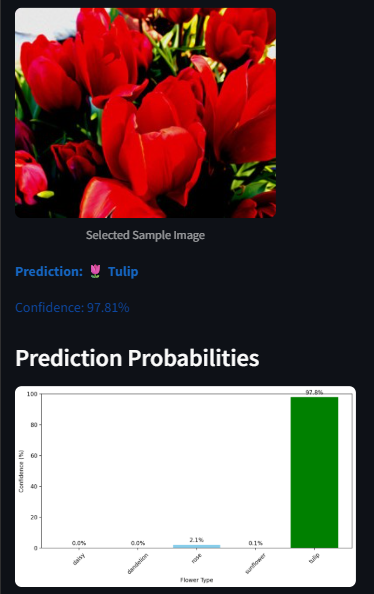

| Tahapan Konsep Slide                          | Kode Python                                           | Penjelasan                                                                                        |
| --------------------------------------------- | ----------------------------------------------------- | ------------------------------------------------------------------------------------------------- |
| **1. Load Dataset**                           | `image_dataset_from_directory(...)`                   | Sesuai slide, kita mempersiapkan data baru (tugas baru) yang berbeda dari pretrain                |
| **2. Preprocessing & Augmentasi**             | `preprocess_input`, `data_augmentation`               | Mempersiapkan input gambar agar sesuai standar DenseNet121 + augmentasi untuk memperkuat model    |
| **3. Transfer Learning – Feature Extraction** | `base_model.trainable = False`                        | Sesuai slide "Feature Reuse" → semua layer pre-trained dibekukan                                  |
| **4. Tambah Classifier Baru**                 | `GlobalAveragePooling2D`, `Dense(...)`                | Ganti layer klasifikasi sesuai jumlah kelas (5 bunga)                                             |
| **5. Training Awal (Feature Extraction)**     | `model.fit(..., epochs=5)`                            | Melatih classifier baru saja, pretrained model dibekukan                                          |
| **6. Transfer Learning – Fine Tuning**        | `base_model.trainable = True`, `unfreeze layer[-20:]` | Sesuai slide "Fine Tuning" → unfreeze sebagian layer akhir dan retrain dengan learning rate kecil |
| **7. Evaluasi Model**                         | `classification_report(...)`                          | Mengukur akurasi, presisi, dan recall – sesuai permintaan tugas                                   |
| **8. Simpan Model**                           | `model.save(...)`                                     | Untuk reuse model nanti (inference atau deploy)                                                   |
| **9. Prediksi Gambar Baru (Demo/Video)**      | `predict_image(...)`                                  | Fungsi tambahan untuk presentasi dan validasi model                                               |
